In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

In [6]:
def dmd(X, Y, truncate=None):
    '''
    version created by Robert Taylor
    for more info: https://humaticlabs.com/blog/dmd-python/

    in this funciton, truncate == r
    '''
    if truncate == 0:
        # return empty vectors
        mu = np.array([], dtype='complex')
        Phi = np.zeros([X.shape[0], 0], dtype='complex')
    else:
        U2,Sig2,Vh2 = svd(X, False) # SVD of input matrix
        r = len(Sig2) if truncate is None else truncate # rank truncation
        U = U2[:,:r]
        Sig = diag(Sig2)[:r,:r]
        V = Vh2.conj().T[:,:r]
        Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig)) # build A tilde
        mu,W = eig(Atil)
        Phi = dot(dot(dot(Y, V), inv(Sig)), W) # build DMD modes
    return mu, Phi

def svht(X, sv=None):
    # svht for sigma unknown
    m,n = sorted(X.shape) # ensures m <= n
    beta = m / n # ratio between 0 and 1
    if sv is None:
        sv = svdvals(X)
    sv = np.squeeze(sv)
    omega_approx = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
    return np.median(sv) * omega_approx

def mrdmd(D, level=0, bin_num=0, offset=0, max_levels=20, max_cycles=2, do_svht=True):
    """
    Compute the multi-resolution DMD on the dataset `D`, returning a list of nodes
    in the hierarchy. Each node represents a particular "time bin" (window in time) at
    a particular "level" of the recursion (time scale). The node is an object consisting
    of the various data structures generated by the DMD at its corresponding level and
    time bin. The `level`, `bin_num`, and `offset` parameters are for record keeping 
    during the recursion and should not be modified unless you know what you are doing.
    The `max_levels` parameter controls the maximum number of levels. The `max_cycles`
    parameter controls the maximum number of mode oscillations in any given time scale 
    that qualify as "slow". The `do_svht` parameter indicates whether or not to perform
    optimal singular value hard thresholding.

    More info here: https://humaticlabs.com/blog/mrdmd-python/
    """

    # 4 times nyquist limit to capture cycles
    nyq = 8 * max_cycles

    # time bin size
    bin_size = D.shape[1]
    if bin_size < nyq:
        return []

    # extract subsamples 
    step = floor(bin_size / nyq) # max step size to capture cycles
    _D = D[:,::step]
    X = _D[:,:-1]
    Y = _D[:,1:]

    # determine rank-reduction
    if do_svht:
        _sv = svdvals(_D)
        tau = svht(_D, sv=_sv)
        r = sum(_sv > tau)
    else:
        r = min(X.shape)

    # compute dmd
    mu,Phi = dmd(X, Y, r)

    # frequency cutoff (oscillations per timestep)
    rho = max_cycles / bin_size

    # consolidate slow eigenvalues (as boolean mask)
    slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho
    n = sum(slow) # number of slow modes

    # extract slow modes (perhaps empty)
    mu = mu[slow]
    Phi = Phi[:,slow]

    if n > 0:

        # vars for the objective function for D (before subsampling)
        Vand = np.vander(power(mu, 1/step), bin_size, True)
        P = multiply(dot(Phi.conj().T, Phi), np.conj(dot(Vand, Vand.conj().T)))
        q = np.conj(diag(dot(dot(Vand, D.conj().T), Phi)))

        # find optimal b solution
        b_opt = solve(P, q).squeeze()

        # time evolution
        Psi = (Vand.T * b_opt).T

    else:

        # zero time evolution
        b_opt = np.array([], dtype='complex')
        Psi = np.zeros([0, bin_size], dtype='complex')

    # dmd reconstruction
    D_dmd = dot(Phi, Psi)   

    # remove influence of slow modes
    D = D - D_dmd

    # record keeping
    node = type('Node', (object,), {})()
    node.level = level            # level of recursion
    node.bin_num = bin_num        # time bin number
    node.bin_size = bin_size      # time bin size
    node.start = offset           # starting index
    node.stop = offset + bin_size # stopping index
    node.step = step              # step size
    node.rho = rho                # frequency cutoff
    node.r = r                    # rank-reduction
    node.n = n                    # number of extracted modes
    node.mu = mu                  # extracted eigenvalues
    node.Phi = Phi                # extracted DMD modes
    node.Psi = Psi                # extracted time evolution
    node.b_opt = b_opt            # extracted optimal b vector
    nodes = [node]

    # split data into two and do recursion
    if level < max_levels:
        split = ceil(bin_size / 2) # where to split
        nodes += mrdmd(
            D[:,:split],
            level=level+1,
            bin_num=2*bin_num,
            offset=offset,
            max_levels=max_levels,
            max_cycles=max_cycles,
            do_svht=do_svht
            )
        nodes += mrdmd(
            D[:,split:],
            level=level+1,
            bin_num=2*bin_num+1,
            offset=offset+split,
            max_levels=max_levels,
            max_cycles=max_cycles,
            do_svht=do_svht
            )

    return nodes

def stitch(nodes, level):
    
    # get length of time dimension
    start = min([nd.start for nd in nodes])
    stop = max([nd.stop for nd in nodes])
    t = stop - start

    # extract relevant nodes
    nodes = [n for n in nodes if n.level == level]
    nodes = sorted(nodes, key=lambda n: n.bin_num)
    
    # stack DMD modes
    Phi = np.hstack([n.Phi for n in nodes])
    
    # allocate zero matrix for time evolution
    nmodes = sum([n.n for n in nodes])
    Psi = np.zeros([nmodes, t], dtype='complex')
    
    # copy over time evolution for each time bin
    i = 0
    for n in nodes:
        _nmodes = n.Psi.shape[0]
        Psi[i:i+_nmodes,n.start:n.stop] = n.Psi
        i += _nmodes
    
    return Phi,Psi

def mr_recon(D):
    nodes = mrdmd(D)
    
    Phi0,Psi0 = stitch(nodes, 0)
    Phi1,Psi1 = stitch(nodes, 1)
    Phi2,Psi2 = stitch(nodes, 2)
    
    levels = sorted({nd.level for nd in nodes})
    D_hat_full = sum(stitch(nodes, l)[0] @ stitch(nodes, l)[1] for l in levels)
    
    D_iter = None
    for l in levels:
        fig, axes = plt.subplots(1,2, figsize=(15,5))
        ax = axes[1]
        _d = stitch(nodes, l)[0] @ stitch(nodes, l)[1]
        sns.heatmap(_d.real, cbar=False, square=True, ax=ax)
        ax.set_axis_off()
        
        if D_iter is None:
            D_iter = _d.real
        else:
            D_iter = D_iter + _d.real
            
        ax = axes[0]
        sns.heatmap(D_iter, cbar=False, square=True, ax=ax)
        ax.set_axis_off()
        plt.show()
        
    return nodes

def plot_eigs(nodes, levels, combined=False):
    p = np.linspace(0, 2*np.pi, 100)
    
    if combined:
        # all on one plot
        fix,ax = plt.subplots(1,1)
        ax.plot(np.cos(p), np.sin(p), c="k")
        
        for l in levels:
            ns = [n for n in nodes if n.level == l]
            eigs = []
            for n in ns:
                eigs.extend(n.mu)
            eigs = np.array(eigs)
            ax.scatter(eigs.real, eigs.imag, alpha=0.25, label=l)
        
        ax.set_aspect("equal")
        ax.set_title('wrt unit circle')
        ax.legend()
        ax.set_xlim(left = 0)
        
        ax.set_xlabel('Re'); ax.set_ylabel('Im')
    else:
        fix,axes = plt.subplots(1,len(levels), sharey=True)
        # plot unit circle
        for idx,l in enumerate(levels):
            ax = axes[idx]
            ax.plot(np.cos(p), np.sin(p), c="k")
            
            ns = [n for n in nodes if n.level == l]
            eigs = []
            for n in ns:
                eigs.extend(n.mu)
            eigs = np.array(eigs)
            ax.scatter(eigs.real, eigs.imag, alpha=.5, c='red', label=l)
        
            ax.set_aspect("equal")
            ax.set_xlim(left = 0, right=1.2)
            ax.set_title(f'level {l}')
            ax.set_axis_off()
    plt.show()
    
def level_energy(nodes):
    levs = sorted({n.level for n in nodes})
    E = []
    for ℓ in levs:
        Phi, Psi = stitch(nodes, ℓ)
        E.append(np.linalg.norm(Phi @ Psi, 'fro')**2)
    E = np.array(E); return E / E.sum()

In [49]:
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, ('face_roi_data.pkl')))
print(f'Unique face ROIs: {list(dat['roi'].unique())}')

img_sets = {
    "all_faces":  np.arange(1000, 1024),
    "all_bodies": np.concatenate([
        np.arange(1025, 1031),
        np.arange(1042, 1048),
        np.arange(1049, 1061)
    ]),
    "all_objects": np.concatenate([
        np.arange(1024,1025),
        np.arange(1031, 1042),
        np.arange(1048,1049),
        np.arange(1061, 1072)
    ])
}

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [53]:
ROI = 'MF1_8_F' # Unknown_19_F, MF1_8_F, MF1_9_F, MB1_3_B, MB2_20_B, Unknown_27_B, Unknown_22_O, MO2_21_O
PVAL = 0.05

# load in per-image psth
sig = dat[dat['p_value'] < PVAL]
df = sig[sig['roi'] == ROI]
X = np.stack(df['img_psth'].to_numpy())
print(f'Loaded unit-level data for each image. Shape:', X.shape, '---> (units, time points, images)')

# center the data per unit and per image
X_centered = X - X.mean(axis=1, keepdims=True)
print('Centered shape:', X_centered.shape)

Loaded unit-level data for each image. Shape: (1409, 450, 1072) ---> (units, time points, images)
Centered shape: (1409, 450, 1072)


In [54]:
Edf = pd.DataFrame(columns=['level', 'energy', 'category'])

for k, v in img_sets.items():
    # dmd nodes for each image
    nodes = [mrdmd(X_centered[:, :, i]) for i in v]
    
    E_cat = np.vstack([level_energy(n) for n in nodes])

    # store all values, one row per image × level
    for img_idx in range(E_cat.shape[0]):
        for level_idx in range(E_cat.shape[1]):
            Edf.loc[len(Edf)] = {
                'level': level_idx,
                'energy': E_cat[img_idx, level_idx],
                'category': k.split('_')[-1]
            }

/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_89600/1501709745.py:78: RuntimeWarning: invalid value encountered in log
  slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho


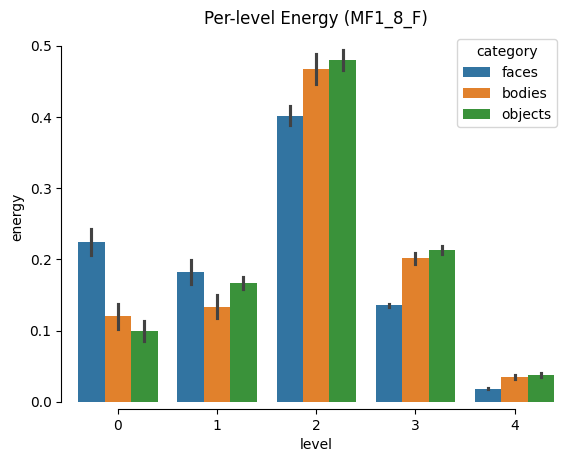

In [55]:
fig,ax = plt.subplots(1,1)
sns.barplot(data=Edf, x='level', y='energy', hue='category', estimator = 'median', errorbar='se', ax=ax)
ax.set_title(f'Per-level Energy ({ROI})')
sns.despine(fig=fig, trim=True, offset=5)
plt.show()